# Entorno de trabajo: Crear un dataset de noticias de prensa a partir del motor de búsqueda Sophia

Este notebook muestra una manera de extraer noticias desde el motor de búsqueda de _Sophia_, a partir de una **palabra clave**, un **país** y un **periodo de tiempo**.


_Sophia_ es un proyecto I+i+D desarrollado en la Universidad Austral de Chile desde 2019. El motor de búsqueda se encuentra en fase de mejoramiento continuo. Por cualquier pregunta o problema técnica con este notebook, no dudar en contactarme por Discord (@MatthieuVernier) o por correo mvernier@inf.uach.cl.

## 0. Librerías útiles

- Elasticsearch es el motor de búsqueda utilizado por Sophia
- Requiere la instalación del paquete elasticsearch

In [1]:
import elasticsearch
from datetime import datetime

## 1. Parámetros de la búsqueda

Características del motor de búsqueda:  
- El formato de las fechas es: YYYY-MM-DD
- El motor de búsqueda incluye noticias por distintos paises, pero se recomienda utilizar "chile" por el momento.
- El motor de búsqueda incluye datos entre el año 2000 y el año 2021.

In [2]:
country="chile"
from_="2021-12-23"
to_="2021-12-30"
media_outlets=["elllanquihue","elaustral","laestrelladechiloe","elheraldoaustral","radiosago",
               "elrepuertero","elvacanudo","elhuemul","seminariolocal","elquellonino","elinsular",
               "radiopudeto","radioacogida","elcalbucano","segundos33",
               "prensadelestuario","fresiaahora","soychiloe"]

keyword=["Puerto Mont", "Osorno"]
simple_keyword=False

## 2. Parámetros de conexión al motor de búsqueda de Sophia

In [3]:
IP = "search.sophia2.org"
PORT = 9200
USER= "elastic"
PASS= "dummy_elastic"

In [4]:
#NO MODIFICAR

es = elasticsearch.Elasticsearch(
    IP,
    #port=PORT,
    http_auth=(USER, PASS)
)

## 3. Búsqueda de noticias de prensa

- Preparación de la consulta en el formato solicitado por Elasticsearch

In [5]:
#NO MODIFICAR
match=""
if (simple_keyword):
    match="match"
else:
    match="match_phrase"

query = { 
    "bool": { 
      # Lo de abajo se descomenta si hay una keyword
      # "must": [
      #   {match: { "text":keyword}}

      # ],
    "filter": [
        {"range": {
      "date": {
        "gte": from_,
        "lt": to_
      }}},
        { "term":  { "country": country }},
        { "terms":  { "media_outlet": media_outlets }} 
    ]
    }  
}

- Envio de la consulta
- No se puede devolver más de 10.000 noticias. En caso de obtener 10.000 respuestas, se recomienda buscar en un periodo de tiempo más corto o modificar la consulta.

In [6]:
res = es.search(index="news", query=query, size=10000)
print("Son %d noticias encontradas..." % res['hits']['total']['value'])

Son 1598 noticias encontradas...


## 4. Guardar los datos en un dataframe Pandas y en un archivo CSV

In [7]:
import pandas as pd

data = {'id_news':[],'country':[],'media_outlet':[],'url':[],'title':[],'text':[],'date':[],'search':[]}

df = pd.DataFrame(data)  
  
for hit in res['hits']['hits']:
    id_news = hit['_source']['id_news']
    country = hit['_source']['country']
    media_outlet = hit['_source']['media_outlet']
    url = hit['_source']['url']
    title = hit['_source']['title']
    text = hit['_source']['text']
    date = hit['_source']['date']
    search = keyword
    
    new_row = {'id_news':id_news, 'country':country, 'media_outlet':media_outlet, 'url':url, 'title':title, 'text':text, 'date':date, 'search':search}
    
    df = df.append(new_row, ignore_index=True)

df

/tmp/ipykernel_1306/2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_1306/2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_1306/2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_1306/2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_1306/2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

,id_news,country,media_outlet,url,title,text,date,search
0,21887359.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-pu...,Cámara de Comercio Puerto Montt responde a alc...,Cabe recordar que luego que el gremio presenta...,2021-12-24,"[Puerto Mont, Osorno]"
1,21909705.0,chile,radiosago,https://www.radiosago.cl/dos-casas-destruidas-...,Dos casas destruidas y varios damnificados dej...,Dos casas completamente destruidas por la acci...,2021-12-29,"[Puerto Mont, Osorno]"
2,21909753.0,chile,radiosago,https://www.radiosago.cl/42-contagios-de-covid...,42 contagios de covid-19 se reportaron este ma...,"Así lo informó la Seremi de Salud Los Lagos, d...",2021-12-28,"[Puerto Mont, Osorno]"
3,21909759.0,chile,radiosago,https://www.radiosago.cl/pesar-por-fallecimien...,Pesar por fallecimiento del Rector creador de ...,Pesar ha manifestado la comunidad de la Sede P...,2021-12-27,"[Puerto Mont, Osorno]"
4,21909775.0,chile,radiosago,https://www.radiosago.cl/desconocidos-danaron-...,Desconocidos dañaron bolos de forraje de agric...,"Durante horas de la noche de este domingo, en ...",2021-12-27,"[Puerto Mont, Osorno]"
...,...,...,...,...,...,...,...,...
1593,47535151.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Colo Colo regaló a hinchas la llegada de Crist...,"La noche del viernes todos los chilenos, al ig...",2021-12-26,"[Puerto Mont, Osorno]"
1594,47535152.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Ben Brereton Díaz fue incluido en el equipo id...,El delantero de la selección nacional Ben Brer...,2021-12-26,"[Puerto Mont, Osorno]"
1595,47535158.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Van cinco mujeres que acusan de abuso a actor ...,Una quinta mujer acusó de abuso sexual al acto...,2021-12-26,"[Puerto Mont, Osorno]"
1596,47550808.0,chile,elvacanudo,https://www.elvacanudo.cl/noticia/sociedad/com...,¿Cómo se llama el martillo de Thor? La curiosa...,Con el estreno de la nueva película de Spiderm...,2021-12-29,"[Puerto Mont, Osorno]"


- Verifiquemos si existen noticias con la misma URL

In [8]:
df['url'].duplicated().any()

True

- Eliminar las noticias duplicadas

In [9]:
df = df.drop_duplicates(subset='url', keep='first')

In [10]:
#Guardo el df en una variable auxiliar para no perderlo
corpus = df

In [11]:
df

,id_news,country,media_outlet,url,title,text,date,search
0,21887359.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-pu...,Cámara de Comercio Puerto Montt responde a alc...,Cabe recordar que luego que el gremio presenta...,2021-12-24,"[Puerto Mont, Osorno]"
1,21909705.0,chile,radiosago,https://www.radiosago.cl/dos-casas-destruidas-...,Dos casas destruidas y varios damnificados dej...,Dos casas completamente destruidas por la acci...,2021-12-29,"[Puerto Mont, Osorno]"
2,21909753.0,chile,radiosago,https://www.radiosago.cl/42-contagios-de-covid...,42 contagios de covid-19 se reportaron este ma...,"Así lo informó la Seremi de Salud Los Lagos, d...",2021-12-28,"[Puerto Mont, Osorno]"
3,21909759.0,chile,radiosago,https://www.radiosago.cl/pesar-por-fallecimien...,Pesar por fallecimiento del Rector creador de ...,Pesar ha manifestado la comunidad de la Sede P...,2021-12-27,"[Puerto Mont, Osorno]"
4,21909775.0,chile,radiosago,https://www.radiosago.cl/desconocidos-danaron-...,Desconocidos dañaron bolos de forraje de agric...,"Durante horas de la noche de este domingo, en ...",2021-12-27,"[Puerto Mont, Osorno]"
...,...,...,...,...,...,...,...,...
993,47533038.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,"Con el viejo truco de achicar el envase, Japón...",Hacer envases más pequeños mientras se siguen ...,2021-12-25,"[Puerto Mont, Osorno]"
1008,47533711.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,Desafío Agua para Chile cambia la vida de 750 ...,700 litros de agua semanales era lo que recibí...,2021-12-28,"[Puerto Mont, Osorno]"
1069,47533542.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,Manchester City fue el gran ganador de un Boxi...,"Como es costumbre cada año, en esta fecha se d...",2021-12-27,"[Puerto Mont, Osorno]"
1596,47550808.0,chile,elvacanudo,https://www.elvacanudo.cl/noticia/sociedad/com...,¿Cómo se llama el martillo de Thor? La curiosa...,Con el estreno de la nueva película de Spiderm...,2021-12-29,"[Puerto Mont, Osorno]"


- Guardar los archivos en un CSV

In [13]:
nombre_archivo='news'+"_"+country+"_"+from_+"_"+to_+".csv"
print("El archivo se llama:")
print(nombre_archivo)
df.to_csv("./"+nombre_archivo)

El archivo se llama:
news_chile_2021-12-23_2021-12-30.csv


- Realizar algunas consultas SQL sobre el dataset

In [14]:
from pandasql import sqldf 

In [15]:
noticias = df.text.values.tolist()

In [16]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

In [17]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [18]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [19]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [20]:
noticias[0]

'Cabe recordar que luego que el gremio presentara un recurso de protección contra la Municipalidad de Puerto Montt en la Corte de Apelaciones y un reclamo de ilegalidad en la Contraloría por la falta de fiscalización a los vendedores ambulantes e informales en la ciudad, elñ alcalde Gervoy Paredes dio cuenta de cierta intencionalidad política para no sumarse a la mesa de trabajo interinstitucional para abordar el comercio informal. Al respecto, Eduardo Salazar, presidente de la Cámara de Comercio, Industria y Turismo afirmó que el gremio es “técnico” y vela no solo por los intereses de sus asociados, sino que también por los de la ciudad.  En esa misma línea, Salazar reiteró que la municipalidad no ha controlado a los ambulantes, lo que permite su proliferación ya que a diario se ve como más calles y veredas son tomadas para ofrecer distintos productos de manera irregular. Cabe consignar que las acciones de la Cámara de Comercio de Puerto Montt tendrán una arista administrativa en la C

In [21]:
text_to_list(noticias[0])

['gremio',
 'recurso',
 'protección',
 'reclamo',
 'ilegalidad',
 'falta',
 'fiscalización',
 'vendedores',
 'ciudad',
 'elñ',
 'alcalde',
 'cuenta',
 'intencionalidad',
 'mesa',
 'trabajo',
 'comercio',
 'respecto',
 'presidente',
 'gremio',
 'solo',
 'intereses',
 'asociados',
 'ciudad',
 'línea',
 'municipalidad',
 'ambulantes',
 'proliferación',
 'diario',
 'calles',
 'veredas',
 'productos',
 'manera',
 'acciones',
 'arista',
 'fin',
 'modificación',
 'ordenanza',
 'venta',
 'gremio',
 'acción',
 'tribunales',
 'organismo',
 'vez',
 'autoridades',
 'funciones',
 'ley',
 'Gervoy Paredes',
 'Eduardo Salazar',
 'recurso de protección',
 'reclamo de ilegalidad',
 'falta de fiscalización',
 'vendedores ambulantes',
 'intencionalidad política',
 'mesa de trabajo',
 'trabajo interinstitucional',
 'comercio informal',
 'productos de manera',
 'manera irregular',
 'arista administrativa',
 'venta informal',
 'gremio puertomontino',
 'acción judicial',
 'organismo público',
 'autoridades lo

In [22]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

In [23]:
N=5
print(noticias[N])
print(noticias_procesadas[5])

 }ext-align: center; {67px) {nath Quinteros emplazara al Servicio de Salud Reloncaví a dar luz verde al proyecto de Centro Oncológico en Puerto Montt de la Fundación Arturo López Pérez, el director de dicho servicio de salud, el Dr. Jorge Tagle, aseguró que ven con muy buenos ojos que llegue un actor privado de atención oncológica a la zona, y siempre han estado abiertos a reunirse con la fundación para abordar los alcances de su proyecto. En ese marco, el Dr. Tagle indicó que en cuanto al terreno que se ha mencionado como un obstáculo para el desarrollo del proyecto, señaló que el MINSAL siempre ha estado dispuesto a evaluar las posibilidades, que fue la instrucción que recibieron del nivel central y así se ha hecho. El director del Servicio de Salud Reloncaví explicó que no pueden disponer de un terreno estratégico y entregárselo a una entidad privada, apelando a una lógica de Estado y salud pública.  El Dr. Jorge Tagle, defendió dicha determinación asegurando que reafirma la intenci

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

In [25]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

# View
print(dataset[:N])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)], [(3, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1)], [(76, 1), (94, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1)

In [26]:
n_topicos = 12
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=n_topicos, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.043*"niños" + 0.012*"niñas" + 0.010*"medios" + 0.010*"prensa" + '
  '0.009*"destino" + 0.008*"información" + 0.008*"empleo" + '
  '0.008*"capacitación" + 0.008*"curso" + 0.007*"estrategias" + 0.006*"imagen" '
  '+ 0.006*"viajeros" + 0.006*"libertad" + 0.006*"emprendimiento" + '
  '0.006*"innovación" + 0.006*"ciudadanos" + 0.006*"radio" + 0.006*"cupos" + '
  '0.005*"adolescentes" + 0.005*"miembros" + 0.005*"viajes" + 0.005*"campaña" '
  '+ 0.005*"práctica" + 0.005*"felicidad" + 0.004*"objetivo" + '
  '0.004*"fenómeno" + 0.004*"iniciativa" + 0.004*"turismo" + 0.004*"diputado '
  'electo" + 0.004*"documento" + 0.004*"profesores" + 0.004*"educación" + '
  '0.004*"amenazas" + 0.004*"naciones" + 0.004*"petición" + 0.003*"sendero" + '
  '0.003*"esencia" + 0.003*"aspecto" + 0.003*"juguetes" + 0.003*"conocimiento" '
  '+ 0.003*"relevancia" + 0.003*"asistentes" + 0.003*"alegría" + '
  '0.003*"comunicación" + 0.003*"constituyentes" + 0.003*"mandato" + '
  '0.003*"acceso" + 0.003*"proced

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecat

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.325649  0.048507       1        1  48.483641
6      0.229126 -0.222009       2        1  16.507393
7      0.101505  0.247303       3        1   9.378466
2     -0.022429 -0.019884       4        1   5.376943
8     -0.058797 -0.015611       5        1   4.354837
5     -0.091406 -0.026848       6        1   4.213052
0     -0.063669 -0.033420       7        1   4.000562
1     -0.020987  0.079059       8        1   3.609399
11    -0.069861 -0.014720       9        1   2.289832
9     -0.111281 -0.016997      10        1   0.998075
10    -0.111842 -0.012388      11        1   0.454976
4     -0.106007 -0.012992      12        1   0.332824, topic_info=                                Term        Freq       Total Category  \
921                             agua  201.000000  201.000000  Default   
1065                           niños  138.000000  138.000000  Default   
319                           sector  240.000000  240.000000  Default   
933                         familias  181.000000  181.000000  Default   
68                            comuna  259.000000  259.000000  Default   
...                              ...         ...         ...      ...   
1334                       facultado    0.074637    0.746196  Topic12   
1322  Conaf de la Región de Los Ríos    0.074637    0.746195  Topic12   
955                        concejala    0.316394    3.652062  Topic12   
1331                         consejo    0.268248    8.102999  Topic12   
1347                         árboles    0.324499   23.676329  Topic12   

      logprob  loglift  
921   30.0000  30.0000  
1065  29.0000  29.0000  
319   28.0000  28.0000  
933   27.0000  27.0000  
68    26.0000  26.0000  
...       ...      ...  
1334  -8.0051   3.4030  
1322  -8.0051   3.4030  
955   -6.5607   3.2593  
1331  -6.7258   2.2972  
1347  -6.5354   1.4154  

[579 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
8427     11  0.810179   1931
3617     11  0.554669   1975
8428     11  0.810179   1976
8429     11  0.674093   1977
1661     11  0.482656   1984
...     ...       ...    ...
2037      2  0.310972  áreas
2037      3  0.641379  áreas
2037      6  0.038871  áreas
271       1  0.995084  época
1067     12  0.939545  éxito

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 8, 3, 9, 6, 1, 2, 12, 10, 11, 5])

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.054955567977624

Coherence Score:  0.4598103137749401


In [30]:
#Análisis de mejor número de tópicos
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
start=2
limit=15
step=2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12
14


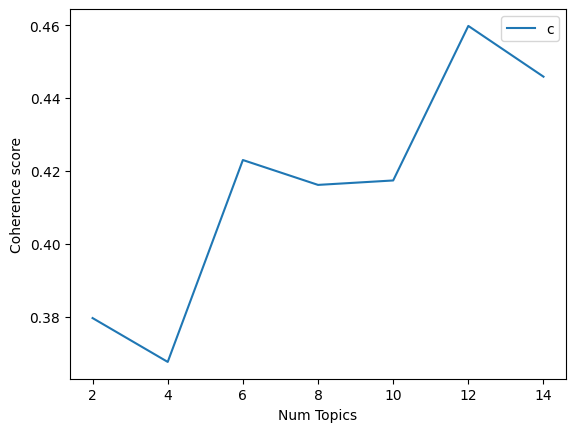

In [32]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3796
Num Topics = 4  has Coherence Value of 0.3676
Num Topics = 6  has Coherence Value of 0.423
Num Topics = 8  has Coherence Value of 0.4162
Num Topics = 10  has Coherence Value of 0.4174
Num Topics = 12  has Coherence Value of 0.4598
Num Topics = 14  has Coherence Value of 0.4459


In [34]:
optimal_model = model_list[5]

In [35]:
archivo='./output/optimal_model_los_lagos'

In [36]:

optimal_model.save(archivo)

In [37]:
from gensim.models import LdaModel

optimal_model = LdaModel.load(archivo, mmap='r')

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, dataset, id2word)
vis

/home/cerdamara/miniconda3/envs/lenguaje/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.325649  0.048507       1        1  48.483641
6      0.229126 -0.222009       2        1  16.507393
7      0.101505  0.247303       3        1   9.378466
2     -0.022429 -0.019884       4        1   5.376943
8     -0.058797 -0.015611       5        1   4.354837
5     -0.091406 -0.026848       6        1   4.213052
0     -0.063669 -0.033420       7        1   4.000562
1     -0.020987  0.079059       8        1   3.609399
11    -0.069861 -0.014720       9        1   2.289832
9     -0.111281 -0.016997      10        1   0.998075
10    -0.111842 -0.012388      11        1   0.454976
4     -0.106007 -0.012992      12        1   0.332824, topic_info=                                Term        Freq       Total Category  \
921                             agua  201.000000  201.000000  Default   
1065                           niños  138.000000  138.000000  Default   
319                           sector  240.000000  240.000000  Default   
933                         familias  181.000000  181.000000  Default   
68                            comuna  259.000000  259.000000  Default   
...                              ...         ...         ...      ...   
1334                       facultado    0.074637    0.746196  Topic12   
1322  Conaf de la Región de Los Ríos    0.074637    0.746195  Topic12   
955                        concejala    0.316394    3.652062  Topic12   
1331                         consejo    0.268248    8.102999  Topic12   
1347                         árboles    0.324499   23.676329  Topic12   

      logprob  loglift  
921   30.0000  30.0000  
1065  29.0000  29.0000  
319   28.0000  28.0000  
933   27.0000  27.0000  
68    26.0000  26.0000  
...       ...      ...  
1334  -8.0051   3.4030  
1322  -8.0051   3.4030  
955   -6.5607   3.2593  
1331  -6.7258   2.2972  
1347  -6.5354   1.4154  

[579 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
8427     11  0.810179   1931
3617     11  0.554669   1975
8428     11  0.810179   1976
8429     11  0.674093   1977
1661     11  0.482656   1984
...     ...       ...    ...
2037      2  0.310972  áreas
2037      3  0.641379  áreas
2037      6  0.038871  áreas
271       1  0.995084  época
1067     12  0.939545  éxito

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 8, 3, 9, 6, 1, 2, 12, 10, 11, 5])

In [39]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/tmp/ipykernel_1306/2723940523.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5,0.6138,"presidente, reconstrucción, comercio, falta, a...",Cabe recordar que luego que el gremio presenta...
1,1,7,0.6592,"sector, incendio, comuna, zona, vecinos, alcal...",Dos casas completamente destruidas por la acci...
2,2,6,0.8422,"personas, casos, dosis, país, año, vacunación,...","Así lo informó la Seremi de Salud Los Lagos, d..."
3,3,3,0.4806,"años, parte, año, trabajo, personas, través, p...",Pesar ha manifestado la comunidad de la Sede P...
4,4,5,0.5347,"presidente, reconstrucción, comercio, falta, a...","Durante horas de la noche de este domingo, en ..."
5,5,3,0.5179,"años, parte, año, trabajo, personas, través, p...",Luego que el Senador Rabindranath Quinteros em...
6,6,6,0.8489,"personas, casos, dosis, país, año, vacunación,...","Así lo informó la Seremi de Salud Los Lagos, d..."
7,7,3,0.6523,"años, parte, año, trabajo, personas, través, p...","De acuerdo a lo informado por Carabineros, la ..."
8,8,3,0.9050,"años, parte, año, trabajo, personas, través, p...",En su calidad de presidente de la comisión de ...
9,9,6,0.8561,"personas, casos, dosis, país, año, vacunación,...","Así lo informó la Seremi de Salud Los Lagos, d..."


In [40]:
media_outlet = corpus.filter(['media_outlet'], axis=1)
df_dominant_topic=df_dominant_topic.join(media_outlet)
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,0,5,0.6138,"presidente, reconstrucción, comercio, falta, a...",Cabe recordar que luego que el gremio presenta...,radiosago
1,1,7,0.6592,"sector, incendio, comuna, zona, vecinos, alcal...",Dos casas completamente destruidas por la acci...,radiosago
2,2,6,0.8422,"personas, casos, dosis, país, año, vacunación,...","Así lo informó la Seremi de Salud Los Lagos, d...",radiosago
3,3,3,0.4806,"años, parte, año, trabajo, personas, través, p...",Pesar ha manifestado la comunidad de la Sede P...,radiosago
4,4,5,0.5347,"presidente, reconstrucción, comercio, falta, a...","Durante horas de la noche de este domingo, en ...",radiosago
...,...,...,...,...,...,...
587,587,6,0.3783,"personas, casos, dosis, país, año, vacunación,...",Hacer envases más pequeños mientras se siguen ...,NaN
588,588,3,0.4045,"años, parte, año, trabajo, personas, través, p...",700 litros de agua semanales era lo que recibí...,laestrelladechiloe
589,589,3,0.7558,"años, parte, año, trabajo, personas, través, p...","Como es costumbre cada año, en esta fecha se d...",laestrelladechiloe
590,590,3,0.8221,"años, parte, año, trabajo, personas, través, p...",Con el estreno de la nueva película de Spiderm...,NaN


In [41]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,0,5,0.6138,"presidente, reconstrucción, comercio, falta, a...",Cabe recordar que luego que el gremio presenta...,radiosago
1,1,7,0.6592,"sector, incendio, comuna, zona, vecinos, alcal...",Dos casas completamente destruidas por la acci...,radiosago
2,2,6,0.8422,"personas, casos, dosis, país, año, vacunación,...","Así lo informó la Seremi de Salud Los Lagos, d...",radiosago
3,3,3,0.4806,"años, parte, año, trabajo, personas, través, p...",Pesar ha manifestado la comunidad de la Sede P...,radiosago
4,4,5,0.5347,"presidente, reconstrucción, comercio, falta, a...","Durante horas de la noche de este domingo, en ...",radiosago
...,...,...,...,...,...,...
587,587,6,0.3783,"personas, casos, dosis, país, año, vacunación,...",Hacer envases más pequeños mientras se siguen ...,NaN
588,588,3,0.4045,"años, parte, año, trabajo, personas, través, p...",700 litros de agua semanales era lo que recibí...,laestrelladechiloe
589,589,3,0.7558,"años, parte, año, trabajo, personas, través, p...","Como es costumbre cada año, en esta fecha se d...",laestrelladechiloe
590,590,3,0.8221,"años, parte, año, trabajo, personas, través, p...",Con el estreno de la nueva película de Spiderm...,NaN


In [42]:
from pandasql import sqldf 

In [43]:
result = sqldf("SELECT Dominant_Topic, count(*) as nb_noticias FROM df_dominant_topic GROUP BY Dominant_Topic ORDER BY count(*) DESC")
result

,Dominant_Topic,nb_noticias
0,3,365
1,6,81
2,7,46
3,2,20
4,1,20
5,11,14
6,8,14
7,5,13
8,0,12
9,9,4


In [44]:
comunas_los_lagos = ['Ancud', 'Castro', 'Chonchi', 'Curaco de Vélez', 'Dalcahue', 'Puqueldón', 'Queilén', 'Quemchi', 'Quellón', 'Quinchao', 'Calbuco', 'Cochamó', 'Fresia', 'Frutillar',
                        'Llanquihue', 'Los Muermos', 'Maullín', 'Puerto Montt', 'Puerto Varas', 'Osorno', 'Puerto Octay', 'Purranque', 'Puyehue', 'Río Negro', 'San Juan de la Costa',
                        'San Pablo', 'Chaitén', 'Futaleufú', 'Hualaihué', 'Palena']

In [45]:
topicos_por_comuna = {}
for i in comunas_los_lagos:
    topicos_por_comuna[i] = []
topicos_por_comuna

{'Ancud': [],
 'Castro': [],
 'Chonchi': [],
 'Curaco de Vélez': [],
 'Dalcahue': [],
 'Puqueldón': [],
 'Queilén': [],
 'Quemchi': [],
 'Quellón': [],
 'Quinchao': [],
 'Calbuco': [],
 'Cochamó': [],
 'Fresia': [],
 'Frutillar': [],
 'Llanquihue': [],
 'Los Muermos': [],
 'Maullín': [],
 'Puerto Montt': [],
 'Puerto Varas': [],
 'Osorno': [],
 'Puerto Octay': [],
 'Purranque': [],
 'Puyehue': [],
 'Río Negro': [],
 'San Juan de la Costa': [],
 'San Pablo': [],
 'Chaitén': [],
 'Futaleufú': [],
 'Hualaihué': [],
 'Palena': []}

In [46]:
for df_element in range (len(df_dominant_topic)):
    for comuna in comunas_los_lagos:
        if comuna in df_dominant_topic['Text'][df_element]:
            print(f"Comuna: {comuna}, n Documento: {df_dominant_topic['Document_No'][df_element]}")
            topicos_por_comuna[comuna].append(df_dominant_topic['Dominant_Topic'][df_element]) 

Comuna: Puerto Montt, n Documento: 0
Comuna: Ancud, n Documento: 1
Comuna: Ancud, n Documento: 2
Comuna: Chonchi, n Documento: 2
Comuna: Puqueldón, n Documento: 2
Comuna: Quellón, n Documento: 2
Comuna: Calbuco, n Documento: 2
Comuna: Frutillar, n Documento: 2
Comuna: Llanquihue, n Documento: 2
Comuna: Puerto Montt, n Documento: 2
Comuna: Puerto Varas, n Documento: 2
Comuna: Osorno, n Documento: 2
Comuna: San Pablo, n Documento: 2
Comuna: Hualaihué, n Documento: 2
Comuna: Palena, n Documento: 2
Comuna: Puerto Montt, n Documento: 3
Comuna: Osorno, n Documento: 3
Comuna: Puerto Montt, n Documento: 5
Comuna: Castro, n Documento: 6
Comuna: Chonchi, n Documento: 6
Comuna: Quellón, n Documento: 6
Comuna: Quinchao, n Documento: 6
Comuna: Calbuco, n Documento: 6
Comuna: Fresia, n Documento: 6
Comuna: Llanquihue, n Documento: 6
Comuna: Maullín, n Documento: 6
Comuna: Puerto Montt, n Documento: 6
Comuna: Puerto Varas, n Documento: 6
Comuna: Osorno, n Documento: 6
Comuna: Puerto Octay, n Document

In [47]:
#topicos_por_comuna

In [48]:
topicos = ['Historia, tiempo, eventos', 'Pandemia', 'Incendios, emergencia', 'Ataques, atentados', 'Ocio, eventos al aire libre', 'Infraestructura, Economía',
            'Estudiantes, emprendimiento', 'Sequía, falta de recursos', 'Drogras, delincuencia', 'Gobierno, elecciones presidenciales', 'Forestal, política']

In [49]:
topicos_por_comuna_desc = {}

for i in comunas_los_lagos:
    topicos_por_comuna_desc[i] = []

for comuna in topicos_por_comuna:
    for topico in topicos_por_comuna[comuna]:
        if topicos[topico-1] not in topicos_por_comuna_desc[comuna]:
            topicos_por_comuna_desc[comuna].append(topicos[topico-1])

In [50]:
topicos_por_comuna_desc

{'Ancud': ['Estudiantes, emprendimiento',
  'Infraestructura, Economía',
  'Incendios, emergencia',
  'Historia, tiempo, eventos',
  'Sequía, falta de recursos'],
 'Castro': ['Infraestructura, Economía',
  'Forestal, política',
  'Estudiantes, emprendimiento',
  'Ocio, eventos al aire libre',
  'Sequía, falta de recursos',
  'Incendios, emergencia'],
 'Chonchi': ['Infraestructura, Economía',
  'Incendios, emergencia',
  'Sequía, falta de recursos',
  'Estudiantes, emprendimiento'],
 'Curaco de Vélez': ['Infraestructura, Economía', 'Incendios, emergencia'],
 'Dalcahue': ['Infraestructura, Economía',
  'Incendios, emergencia',
  'Sequía, falta de recursos',
  'Estudiantes, emprendimiento'],
 'Puqueldón': ['Infraestructura, Economía', 'Incendios, emergencia'],
 'Queilén': ['Incendios, emergencia'],
 'Quemchi': ['Infraestructura, Economía', 'Incendios, emergencia'],
 'Quellón': ['Infraestructura, Economía',
  'Historia, tiempo, eventos',
  'Estudiantes, emprendimiento',
  'Incendios, emerg

In [51]:
topicos_por_comuna_desc['Puerto Montt']

['Ocio, eventos al aire libre',
 'Infraestructura, Economía',
 'Incendios, emergencia',
 'Estudiantes, emprendimiento',
 'Forestal, política',
 'Sequía, falta de recursos']